*Index TODO*

**QUESTION:** Can we model the movements of the Ethereum price?

## Import Libraries

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.3MB/s 
     |████████████████████████████████| 8.7MB 9.0MB/s 
     |████████████████████████████████| 2.1MB 41.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [2]:
import os
import io
import math
import random
import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn
import matplotlib.dates as mdates
import datetime as dt
from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-colorblind')

import warnings
warnings.filterwarnings("ignore")

## Data Engineering

In [3]:
def download_file(url, filename):
    r = requests.get(url, stream=True)

    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    total_kb_size = math.ceil(total_size//block_size)
    
    wrote = 0 
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size), total=total_kb_size , unit='KB', unit_scale=True):
            wrote = wrote  + len(data)
            f.write(data)

In [4]:
datafile = "eth-eur.csv"

#import from server
if not os.path.exists(datafile):
    download_file("https://www.coingecko.com/price_charts/export/279/eur.csv", datafile)


60.0KB [00:00, 3.79kKB/s]


In [5]:
data = pd.read_csv(datafile)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1857 entries, 0 to 1856
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   snapped_at    1857 non-null   object 
 1   price         1857 non-null   float64
 2   market_cap    1856 non-null   float64
 3   total_volume  1857 non-null   float64
dtypes: float64(3), object(1)
memory usage: 58.2+ KB


---
### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [6]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)
features = data.columns

In [7]:
#check
'2015-08-09 00:00:00' in data.index

False

In [8]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

### Filling de NaNs

Now, the index is complete but the inexistent samples must be filled out with some values.

In [9]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [10]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
dtype: int64

### Adding Difference Features

In [11]:
for i in [1,2,3,5,7,15,30,90,180,365]:
    column = "diff{}".format(i)
    data[column] = data.price.diff(i)

data.dropna(inplace=True)
data.head()

,price,market_cap,total_volume,diff1,diff2,diff3,diff5,diff7,diff15,diff30,diff90,diff180,diff365
2016-08-06,9.830444,8.132264e+08,1.054695e+07,-0.037447,-0.081837,0.663582,0.009889,-1.395708,-3.212336,0.701010,1.471286,7.003920,7.250231
2016-08-07,9.845535,8.147967e+08,1.071348e+07,0.015090,-0.022356,-0.066747,2.413940,-0.774393,-3.261346,-0.463954,1.628194,6.550895,8.670229
2016-08-08,10.142127,8.396685e+08,9.891552e+06,0.296592,0.311683,0.274236,0.975265,0.321572,-1.526195,0.194297,1.921620,6.217435,9.242416
2016-08-09,10.962065,9.079042e+08,2.668104e+07,0.819938,1.116530,1.131620,1.049783,3.530470,-1.604636,1.048899,2.225050,5.657944,10.337949
2016-08-10,10.850610,8.990269e+08,2.100154e+07,-0.111455,0.708483,1.005075,0.982719,1.683747,0.139592,1.343402,1.979885,5.985205,9.884003


### Training and Testing Datasets

In [12]:
# 90% for training, 10% for for testing
idx = round(len(data)*0.9)
data_train, data_test = data[:idx], data[idx:]

In [13]:
print("Size data_train: {}".format(data_train.shape[0]))
print("Size data_test: {}".format(data_test.shape[0]))

Size data_train: 1344
Size data_test: 149


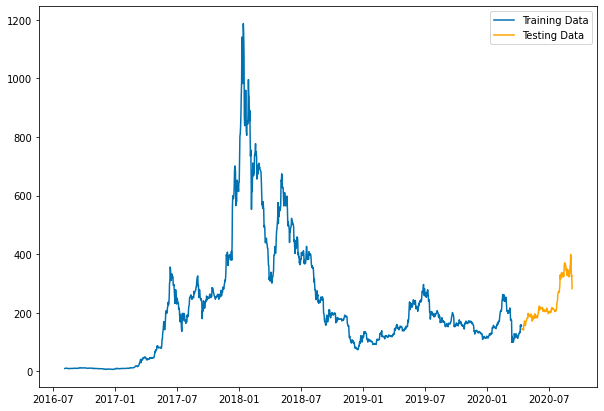

In [14]:
plt.figure(figsize=(10,7))
plt.plot(data_train.price, label='Training Data')
plt.plot(data_test.price, 'orange', label='Testing Data')
plt.legend()

In [15]:
# Removing date before 2017 since it's useless
data_train = data_train['2017-01-01':]
data = data['2017-01-01':]

## Analysis

Decomposing Time Series into several components-Trend, Seasonality and Random noise

**Additive model = Trend + Seasonality + Random Noise**

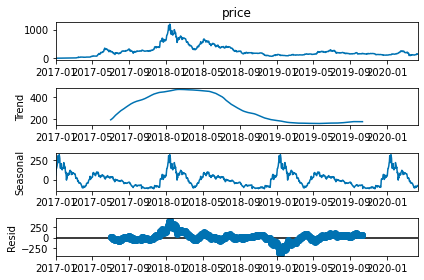

In [16]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(data_train.price, freq=365)

fig=seas_d.plot()
fig.set_figheight(4)

There seems to be no trend... but, is the price **stationary?**
Check it using the **Augmented Dickey-Fuller test**

In [17]:
from statsmodels.tsa.stattools import adfuller

def test_adf(data_series):
    # H0: it's non stationary
    # H1: it's stationary
    result = adfuller(data_series)

    labels = ['ADF test statistic', 'p-value', 'Lags used', 'Observations used']
    for value, label in zip(result, labels):
        print("{}: {}".format(label, value))
    if result[1] <= 0.05:
        print("** H0 is rejected. Stationary.** ")
    else:
        print("** H0 is not rejected. Non stationary. **")

test_adf(data_train.diff3)

ADF test statistic: -5.941590695348668
p-value: 2.2542536945749571e-07
Lags used: 20
Observations used: 1175
** H0 is rejected. Stationary.** 


ADF test statistic: -5.941590695348668
p-value: 2.2542536945749571e-07
Lags used: 20
Observations used: 1175
** H0 is rejected. Stationary.** 


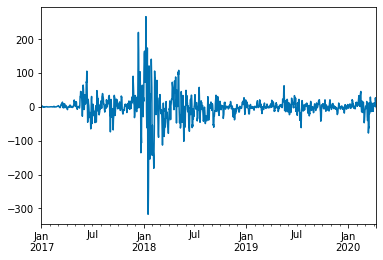

In [18]:
test_adf(data_train.diff3)
data_train.diff3.plot()

Once the series is stabilized, we can plot the ACF and PACF plots to identify the orders of AR and MA terms in the ARIMA model.

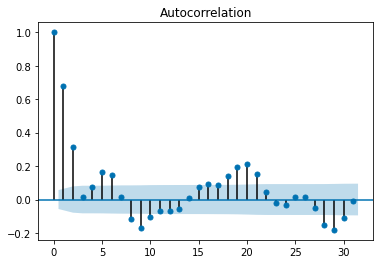

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_train.diff3)
plt.show()

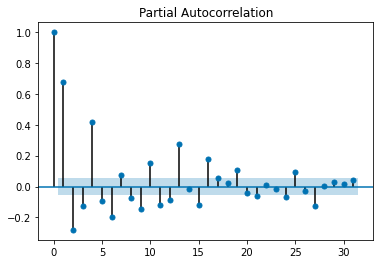

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_train.diff3)
plt.show()

**There is no geometric forms so probably the ARIMA model is not going to help here.**

In any case the most probable order for ARIMA model would be:
* Integrated d=1 #difference
* AR p=0
* MA q=0

## ARIMA

Just in case, we're trying to find any other best order using 'auto ARIMA' from *pmdarima* library.

In [21]:
X_train = data_train.diff3
X_test = data_test.diff3

In [22]:
import pmdarima as pm

model = pm.auto_arima(X_train,
                      #test='adf',
                      d=0,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11933.078, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11193.137, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11382.102, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11097.172, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11079.413, Time=0.18 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=10856.873, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=10848.904, Time=0.28 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=10827.565, Time=1.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=10853.852, Time=0.41 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=1.42 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=1.03 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=10829.521, Time=3.00 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0]          
Total fit time: 8.579 seconds


In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1196
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -5406.783
Date:                Sun, 06 Sep 2020   AIC                          10827.565
Time:                        20:23:04   BIC                          10863.172
Sample:                             0   HQIC                         10840.980
                               - 1196                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5648      0.045     34.944      0.000       1.477       1.653
ar.L2         -0.7132      0.043    -16.487      0.000      -0.798      -0.628
ar.L3         -0.4247      0.024    -17.789      0.000      -0.471      -0.378
ar.L4          0.8227      0.026     32.175      0.000       0.773       0.873
ar.L5         -0.3861      0.016    -24.298      0.000      -0.417      -0.355
ma.L1         -0.6421      0.048    -13.498      0.000      -0.735      -0.549
sigma2       493.7843      8.248     59.871      0.000     477.619     509.949
===================================================================================
Ljung-Box (Q):                      220.10   Jarque-Bera (JB):             15250.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
from statsmodels.tsa.arima_model import ARIMA

start = len(X_train)
end = start + len(X_test)
order = (5,0,1)

# Rolling 1 step with re-estimation
p1 = pd.Series()
for i in range(start, end):
    model = ARIMA(data.diff3[:i], order=order).fit()
    yhat= model.forecast()[0]
    p1[data.index[i]] = yhat

Test MSE in ARIMA: 155.206


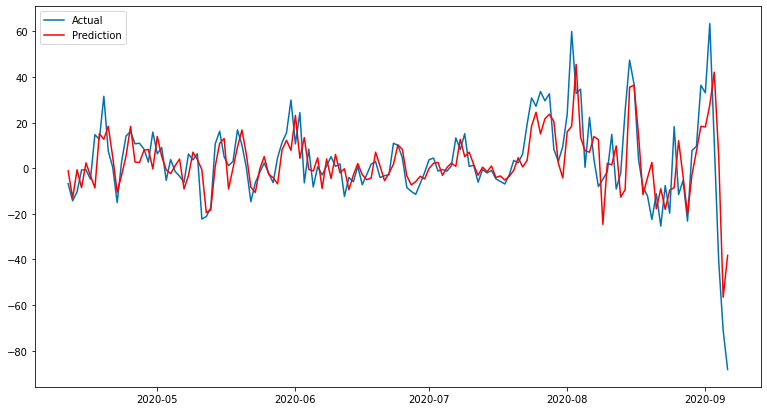

In [25]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(X_test, p1)
print("Test MSE in {}: {:.3f}".format('ARIMA', error))

# plot
plt.figure(figsize=(13,7))
plt.plot(X_test, label='Actual')
plt.plot(p1, color='red', label='Prediction')
plt.legend()
plt.show()

In [26]:
#x_diff = p1.values
#x_diff[0] += X_train[-3] 
#X['price'] = np.r_[x_diff].cumsum().astype(int)
# RE-SCALE

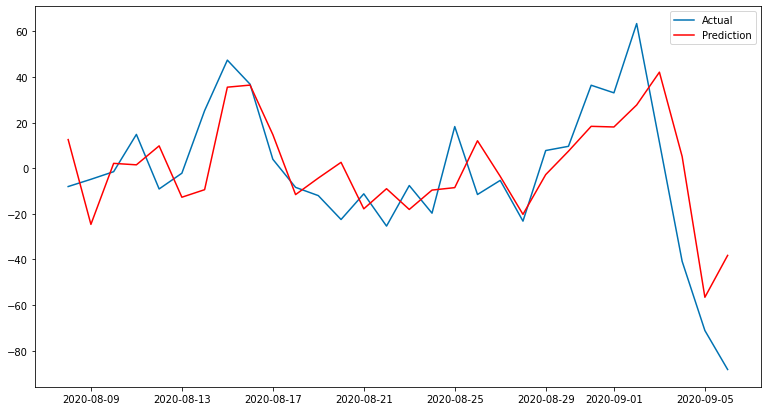

In [27]:
# plot last month
plt.figure(figsize=(13,7))
plt.plot(X_test[-30:], label='Actual')
plt.plot(p1[-30:], color='red', label='Prediction')
plt.legend()
plt.show()

## Random Forest

In [28]:
X_train = data_train.iloc[:,3:]
y_train = data_train.price

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Text(0.5, 0, 'Relative Importance')

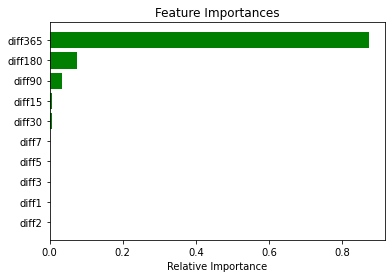

In [30]:
importances = rf.feature_importances_
indices = np.argsort(importances)

#plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel('Relative Importance')


In [31]:
# Refit the model
#rf.fit(X_train[['market_cap','diff90','diff180','diff365']], y_train)
rf.fit(X_train[['diff90','diff180','diff365']], y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [32]:
#X_test = data_test[['market_cap','diff90','diff180','diff365']]
X_test = data_test[['diff90','diff180','diff365']]
y_test = data_test.price

predictions = rf.predict(X_test)

Test MSE in random forest: 9231.649


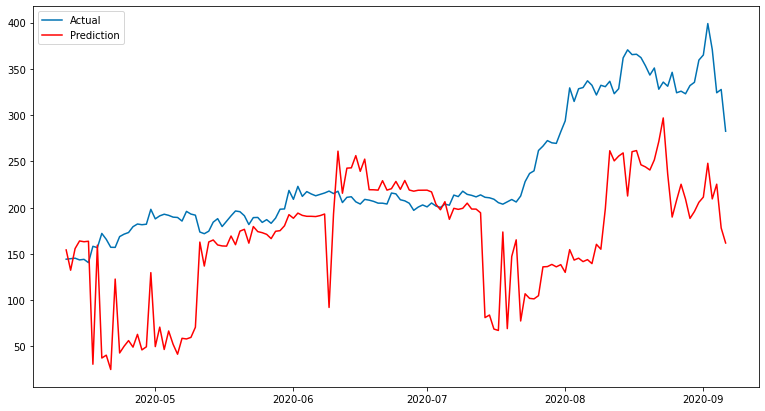

In [33]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test, predictions)
print("Test MSE in random forest: {:.3f}".format(error))

# plot
plt.figure(figsize=(13,7))
plt.plot(data_test.price, label='Actual')
plt.plot(data_test.index, predictions, color='red', label='Prediction')
plt.legend()
plt.show()

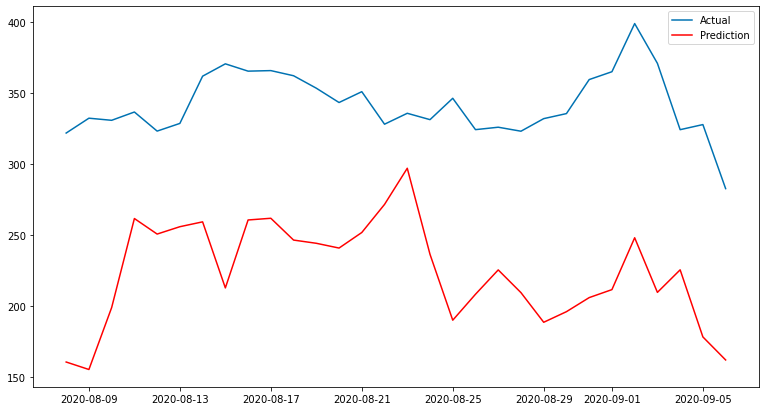

In [34]:
# plot last month
plt.figure(figsize=(13,7))
plt.plot(data_test[-30:].price, label='Actual')
plt.plot(data_test[-30:].index, predictions[-30:], color='red', label='Prediction')
plt.legend()
plt.show()

## LSTM

In [35]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.3.0


The same dataset with differences is going to be used as before (Random Forest model) but now it's going to split the training data into a **validation set** as well.

In [36]:
FEATURES_LEN = len(X_train.columns)

# 90% for training, 10% for validation
idx = round(len(X_train)*0.9)

In [37]:
from sklearn.preprocessing import RobustScaler

# Y
yscaler = RobustScaler()
indices = y_train.index

y_train_norm = yscaler.fit_transform( y_train.values.reshape(-1,1) )
y_train_norm = pd.DataFrame(y_train_norm, index=indices)

y_train_norm, y_val_norm = y_train_norm[:idx], y_train_norm[idx:]

In [38]:
# X
xscaler = RobustScaler()
indices = X_train.index

X_train_norm = xscaler.fit_transform( X_train.values.reshape(-1, FEATURES_LEN) )
X_train_norm = pd.DataFrame(X_train_norm, index=indices)

# Using training dataset with differences -> features
X_train_norm, X_val_norm = X_train_norm[:idx], X_train_norm[idx:]

# Adapt to LSTM sequence shape
X_train_norm = X_train_norm.values.reshape((X_train_norm.shape[0], 1, FEATURES_LEN))
X_val_norm = X_val_norm.values.reshape((X_val_norm.shape[0], 1, FEATURES_LEN))

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(32, input_shape=(1, FEATURES_LEN) ))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

es_callback = EarlyStopping(monitor="loss", min_delta=0, patience=5, restore_best_weights=True)
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), shuffle=False, epochs=100, batch_size=32, verbose=1, callbacks=[es_callback])


Epoch 1/100
34/34 [==============================] - 0s 15ms/step - loss: 1.8653 - val_loss: 0.1129
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 1.7198 - val_loss: 0.1255
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5406 - val_loss: 0.1407
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 1.4435 - val_loss: 0.1603
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 1.2962 - val_loss: 0.1838
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 1.1849 - val_loss: 0.2060
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 1.0991 - val_loss: 0.2304
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 1.0172 - val_loss: 0.2499
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 0.9728 - val_loss: 0.2675
Epoch 10/100
34/34 [==============================] - 0s 2ms/step - loss: 0.8992 - val_loss: 0.2773
Epoch 11

In [40]:
def visualize_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(8,4.5))
    plt.plot(epochs, loss, label="Training loss")
    plt.plot(epochs, val_loss, label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def visualize_plot(model, X, y, title):
    index = y.index
    pred = model.predict(X)
    pred = yscaler.inverse_transform(pred)
    y = yscaler.inverse_transform(y)
    plt.figure(figsize=(8,4.5))
    plt.plot(index, y, label='Actual')
    plt.plot(index, pred, "red", label='Prediction')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Price (€)")
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.gcf().autofmt_xdate()

def print_mse(X, y, title):
    pred = model.predict(X)
    y_rescaled = yscaler.inverse_transform(y)
    pred_rescaled = yscaler.inverse_transform(pred)
    error = mean_squared_error(y_rescaled, pred_rescaled)
    print("{} MSE: {:.3f}".format(title, error))

Training MSE: 2588.285


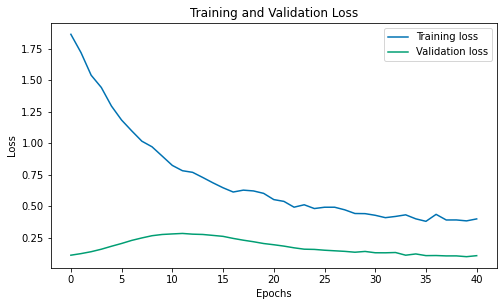

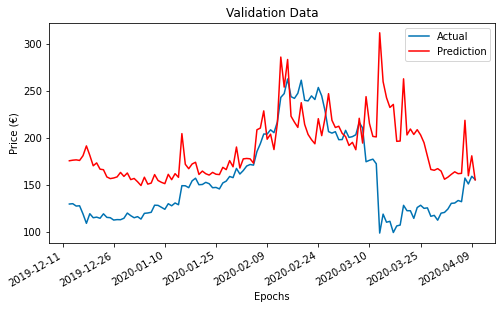

In [41]:
visualize_loss(history)
visualize_plot(model, X_val_norm, y_val_norm, "Validation Data")
print_mse(X_val_norm, y_val_norm, 'Training')

Test MSE: 3479.890


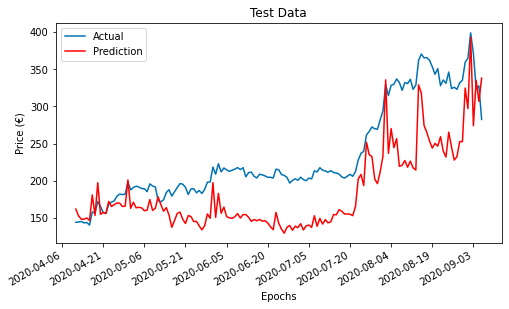

In [42]:
X_test = data_test.iloc[:,3:]
y_test = data_test.price
indices = data_test.index

X_test_norm = xscaler.transform( X_test.values.reshape(-1, FEATURES_LEN) )
X_test_norm = pd.DataFrame(X_test_norm, index=indices)
X_test_norm = X_test_norm.values.reshape((X_test_norm.shape[0], 1, FEATURES_LEN))

y_test_norm = yscaler.transform( y_test.values.reshape(-1,1) )
y_test_norm = pd.DataFrame(y_test_norm, index=indices)

# Plot
visualize_plot(model, X_test_norm, y_test_norm, "Test Data")
print_mse(X_test_norm, y_test_norm, 'Test')

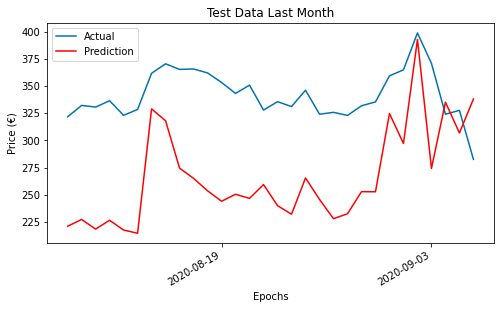

In [43]:
# plot last month
visualize_plot(model, X_test_norm[-30:], y_test_norm[-30:], "Test Data Last Month")

---
## References

Data Trend and Seasonality
* https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
* https://en.wikipedia.org/wiki/Decomposition_of_time_series

AR and MA orders using ACF+PACF
* https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8

Augmented Dickey-Fuller unit root test
* https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html
* https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test
